<a href="https://colab.research.google.com/github/haykalaul/klasifikasi-gambarsampah/blob/main/Klasifikasi_GambarSampah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
arthurwaruwu_datasetcapstonefixx_path = kagglehub.dataset_download('arthurwaruwu/datasetcapstonefixx')

print('Data source import complete.')


Using Colab cache for faster access to the 'datasetcapstonefixx' dataset.
Data source import complete.


# Model 1 Capstone Project : Klasifikasi Gambar Menggunakan Convolutional Neural Networks (CNN)
Notebook ini bertujuan untuk membangun dan melatih model **Convolutional Neural Network (CNN)** untuk melakukan **klasifikasi gambar organik dan anorganik**. Langkah-langkah yang dilakukan meliputi persiapan data, pembuatan model, pelatihan, dan evaluasi model. Model CNN yang dibangun akan digunakan untuk mengklasifikasikan gambar sampah rumah tangga ke dalam dua kategori utama: **organik** dan **anorganik**.

# Nama Proyek : WasteSnap
Proyek inovatif berbasis website yang bertujuan untuk membantu masyarakat Indonesia mengidentifikasi dan mengelola sampah rumah tangga secara mandiri melalui platform berbasis web.

# Tujuan Proyek:
- **Mengidentifikasi Sampah Organik dan Non-Organik**: Dengan menggunakan model CNN yang dilatih pada dataset gambar, pengguna dapat mengidentifikasi jenis sampah secara otomatis.
- **Meningkatkan Kesadaran Lingkungan**: Proyek ini bertujuan untuk meningkatkan kesadaran masyarakat mengenai pengelolaan sampah dan pentingnya pemisahan sampah organik dan non-organik untuk mendukung program daur ulang.
- **Pengelolaan Sampah yang Lebih Efisien**: Dengan aplikasi ini, masyarakat dapat memisahkan sampah mereka dengan lebih mudah dan efisien, serta membantu mengurangi dampak lingkungan yang disebabkan oleh pembuangan sampah sembarangan.

Melalui proyek ini, teknologi klasifikasi gambar diharapkan dapat membantu masyarakat Indonesia dalam pengelolaan sampah rumah tangga secara lebih mandiri dan ramah lingkungan.

# Anggota Tim Machine Learning
## ID tim : CC25-CF318.
Arthur Setiawan Waruwu | MC319D5Y2042 | Universitas Sumatera Utara | \
Sakifa Indira Putri | MC319D5X2380 | Universitas Sumatera Utara | \
Diva Anggreini Harahap | MC319D5X2329 | Universitas Sumatera Utara |

# Penjelasan Dataset
Dataset ini berisi gambar-gambar sampah rumah tangga yang sudah kami kelompokkan dalam folder yang sesuai dengan jenisnya. Dataset ini memiliki 13.8k gambar, yang masing-masing kami kumpulkan secara mandiri dari berbagai sumber, seperti Kaggle, Google Images, Pinterest, dan sumber-sumber lainnya. Berikut adalah kategori-kategori yang terdapat dalam dataset ini:
- Buah
- Cangkang Telur
- Elektronik
- Kaca
- Kain
- Kardus
- Karet
- Kayu
- Kertas
- Kotoran Hewan
- Logam
- Plastik
- Sayuran
- Sepatu
- Sisa Teh dan Kopi
- Sisa Makanan
- Styrofoam

# 1. Import Libraries
Langkah pertama yang akan kita lakukan adalah mengimpor berbagai libraries yang menyediakan fungsi-fungsi yang kita perlukan.

In [2]:
# Install tensorflow menggunakan perintah pip
!pip install tensorflow opencv-python Pillow tensorflowjs

In [3]:
# Import Library yang diperlukan
# Untuk pengolahan citra
import cv2
from PIL import Image, ImageEnhance

# Untuk operasi array dan manipulasi data
import numpy as np
import pandas as pd
import os
import random
import shutil

# Untuk visualisasi
import matplotlib.pyplot as plt  # Matplotlib

# Untuk machine learning / deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs
from tensorflow.keras.models import Model

# 2. Data Preparation
Persiapan data untuk klasifikasi gambar melibatkan pengolahan gambar sehingga dapat dimasukkan ke dalam model CNN.

## Data Loading
Pada bagian ini, kita akan memuat dataset gambar yang akan digunakan untuk train dan validation model. Dataset telah diupload ke kaggle dan akan dimuat langsung ke dalam notebook. Sebelum itu, kita akan menyalin dataset dari direktori `/kaggle/input/` yang sifatnya itu read-only ke direktori working `/kaggle/working/` yang dapat ditulis, jadi kita bisa melakukan berbagai operasi tanpa terbatas oleh izin akses read-only.

In [4]:
dataset_dir = '/kaggle/input/datasetcapstonefixx/Dataset-Asli'

working_dir = '/kaggle/working/dataset-capstone'

if not os.path.exists(dataset_dir):
    print(f"Direktori sumber {dataset_dir} tidak ditemukan!")
else:
    if os.path.exists(working_dir):
        print(f"Folder {working_dir} sudah ada, sedang dihapus...")
        shutil.rmtree(working_dir)

    # menyalin dataset dari /kaggle/input ke /kaggle/working yang bisa ditulis
    try:
        shutil.copytree(dataset_dir, working_dir)
        print(f"Dataset berhasil disalin ke {working_dir}")
    except Exception as e:
        print(f"Gagal menyalin dataset: {e}")

Dataset berhasil disalin ke /kaggle/working/dataset-capstone


In [5]:
# menghitung total gambar di dataset
def count_images_per_class_in_main_folders(base_dir, main_folders):
    total_images = 0

    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            print(f"Folder {main_folder} tidak ditemukan di {base_dir}")
            continue

        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]
        print(f"\nFolder utama '{main_folder}' memiliki {len(kelas_list)} kelas:")

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            images = [f for f in os.listdir(kelas_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            jumlah = len(images)
            print(f"  Kelas '{kelas}' : {jumlah} gambar")
            total_images += jumlah

    print(f"\nTotal seluruh gambar di semua kelas: {total_images}")

main_folders = ['Anorganik', 'Organik']
count_images_per_class_in_main_folders(working_dir, main_folders)


Folder utama 'Anorganik' memiliki 10 kelas:
  Kelas 'Kertas' : 600 gambar
  Kelas 'Elektronik' : 517 gambar
  Kelas 'Karet' : 533 gambar
  Kelas 'Plastik' : 717 gambar
  Kelas 'Kaca' : 750 gambar
  Kelas 'Logam' : 598 gambar
  Kelas 'Kain' : 450 gambar
  Kelas 'Sepatu' : 508 gambar
  Kelas 'Kardus' : 580 gambar
  Kelas 'Styrofoam' : 457 gambar

Folder utama 'Organik' memiliki 7 kelas:
  Kelas 'Kotoran Hewan' : 496 gambar
  Kelas 'Sisa Teh Kopi' : 586 gambar
  Kelas 'Sisa makanan' : 788 gambar
  Kelas 'Kayu' : 533 gambar
  Kelas 'Cangkang Telur' : 660 gambar
  Kelas 'Tumbuhan' : 791 gambar
  Kelas 'Sisa Buah' : 795 gambar

Total seluruh gambar di semua kelas: 10359


In [6]:
# memeriksa ekstensi gambar yang valid
valid_extensions = {'.jpg', '.jpeg', '.png'}

def cek_ekstensi_tidak_valid(base_dir, main_folders):
    invalid_files = []

    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            print(f"Folder {main_folder} tidak ditemukan di {base_dir}")
            continue

        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            files = os.listdir(kelas_path)

            for f in files:
                ext = os.path.splitext(f)[1].lower()
                if ext not in valid_extensions:
                    invalid_files.append(os.path.join(main_folder, kelas, f))

    if invalid_files:
        print("File dengan ekstensi tidak valid ditemukan:")
        for file_path in invalid_files:
            print(f" - {file_path}")
        print(f"\nTotal file dengan ekstensi tidak valid: {len(invalid_files)}")
    else:
        print("Semua file memiliki ekstensi gambar yang valid.")
        print("Total file tidak valid: 0")

# Contoh pemanggilan fungsi
main_folders = ['Anorganik', 'Organik']
cek_ekstensi_tidak_valid(working_dir, main_folders)

File dengan ekstensi tidak valid ditemukan:
 - Anorganik/Elektronik/cfl-waste-recycling.gif
 - Anorganik/Karet/Sasaki M-207BRM Meteor 18_5cm - COG-Cobalt Green _ 18.5cm
 - Anorganik/Karet/MaxPower Rubber Inflatable Tubeless Rib Tread Wheelbarrow Tire 300 lbs_ Capacity 13 Dia. in
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - FFR-Fresh Red _ 18.5cm
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - FRO-Fresh Orange _ 18.5cm
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - RRK-Lilac _ 18.5cm
 - Anorganik/Karet/Unique Bargains Solid Rubber Strips Neoprene Sheets Rolls 1_8_T x 1_97_W x 157.48_L, DIY Rubber Gasket Sealing Padding - Walmart.ca
 - Anorganik/Karet/Ban Luar Tire Kenda Flame 24x2_125 K1008A 24 x 2.125
 - Anorganik/Styrofoam/Bagasse 3 Compartment Meal Box 9_25inch _ 23.5cm
 - Anorganik/Styrofoam/Bagasse Clamshell Lunch Box 18_2 x 13.6 x 4.6cm
 - Anorganik/Styrofoam/Isolierte Lunchbox in Weiß aus XPS - 185 x 155 x 75mm - ca_ 2100ml - 1 Karton (= 500 Stk.)
 - Organik/Kotoran Hew

Melihat dari output di atas, tampaknya masih ada sedikit gambar dengan ekstensi .webp yang tidak valid. Oleh karena itu, kita akan menghapus gambar-gambar ini terlebih dahulu sebelum membagi dataset.

In [7]:
# menghapus gambar yang tidak valid
def hapus_file_tidak_valid(base_dir, main_folders):
    deleted_files = []

    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            print(f"Folder {main_folder} tidak ditemukan di {base_dir}")
            continue

        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            files = os.listdir(kelas_path)

            for f in files:
                ext = os.path.splitext(f)[1].lower()
                if ext not in valid_extensions:
                    file_path = os.path.join(kelas_path, f)
                    try:
                        os.remove(file_path)
                        deleted_files.append(os.path.join(main_folder, kelas, f))
                    except Exception as e:
                        print(f"Gagal menghapus {file_path}: {e}")

    if deleted_files:
        print("Berhasil menghapus file berikut dengan ekstensi tidak valid:")
        for file_path in deleted_files:
            print(f" - {file_path}")
        print(f"\nTotal file yang dihapus: {len(deleted_files)}")
    else:
        print("Tidak ditemukan file dengan ekstensi tidak valid untuk dihapus.")

main_folders = ['Anorganik', 'Organik']
hapus_file_tidak_valid(working_dir, main_folders)

Berhasil menghapus file berikut dengan ekstensi tidak valid:
 - Anorganik/Elektronik/cfl-waste-recycling.gif
 - Anorganik/Karet/Sasaki M-207BRM Meteor 18_5cm - COG-Cobalt Green _ 18.5cm
 - Anorganik/Karet/MaxPower Rubber Inflatable Tubeless Rib Tread Wheelbarrow Tire 300 lbs_ Capacity 13 Dia. in
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - FFR-Fresh Red _ 18.5cm
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - FRO-Fresh Orange _ 18.5cm
 - Anorganik/Karet/Sasaki M-20A Gym Star 18_5cm - RRK-Lilac _ 18.5cm
 - Anorganik/Karet/Unique Bargains Solid Rubber Strips Neoprene Sheets Rolls 1_8_T x 1_97_W x 157.48_L, DIY Rubber Gasket Sealing Padding - Walmart.ca
 - Anorganik/Karet/Ban Luar Tire Kenda Flame 24x2_125 K1008A 24 x 2.125
 - Anorganik/Styrofoam/Bagasse 3 Compartment Meal Box 9_25inch _ 23.5cm
 - Anorganik/Styrofoam/Bagasse Clamshell Lunch Box 18_2 x 13.6 x 4.6cm
 - Anorganik/Styrofoam/Isolierte Lunchbox in Weiß aus XPS - 185 x 155 x 75mm - ca_ 2100ml - 1 Karton (= 500 Stk.)
 - Or

Pada tahap ini, telah dilakukan pengecekan dan penghapusan terhadap gambar-gambar yang tidak valid dalam dataset. Berdasarkan hasil pemeriksaan, sebanyak **34 gambar** dengan ekstensi tidak valid telah dihapus.

In [8]:
def cek_ekstensi_tidak_valid(base_dir, main_folders):
    invalid_files = []

    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            continue

        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            files = os.listdir(kelas_path)

            for f in files:
                ext = os.path.splitext(f)[1].lower()
                if ext not in valid_extensions:
                    invalid_files.append(os.path.join(main_folder, kelas, f))

    if invalid_files:
        print("Masih terdapat file dengan ekstensi tidak valid:")
        for file_path in invalid_files:
            print(f" - {file_path}")
    else:
        print("Tidak ditemukan file dengan ekstensi tidak valid lagi.")

main_folders = ['Anorganik', 'Organik']
cek_ekstensi_tidak_valid(working_dir, main_folders)

Tidak ditemukan file dengan ekstensi tidak valid lagi.


Nah, bisa dipastikan bahwa seluruh gambar dalam dataset ini sudah **valid** dan siap digunakan untuk pelatihan model.


--- Contoh gambar dari kelas di folder 'Anorganik' ---


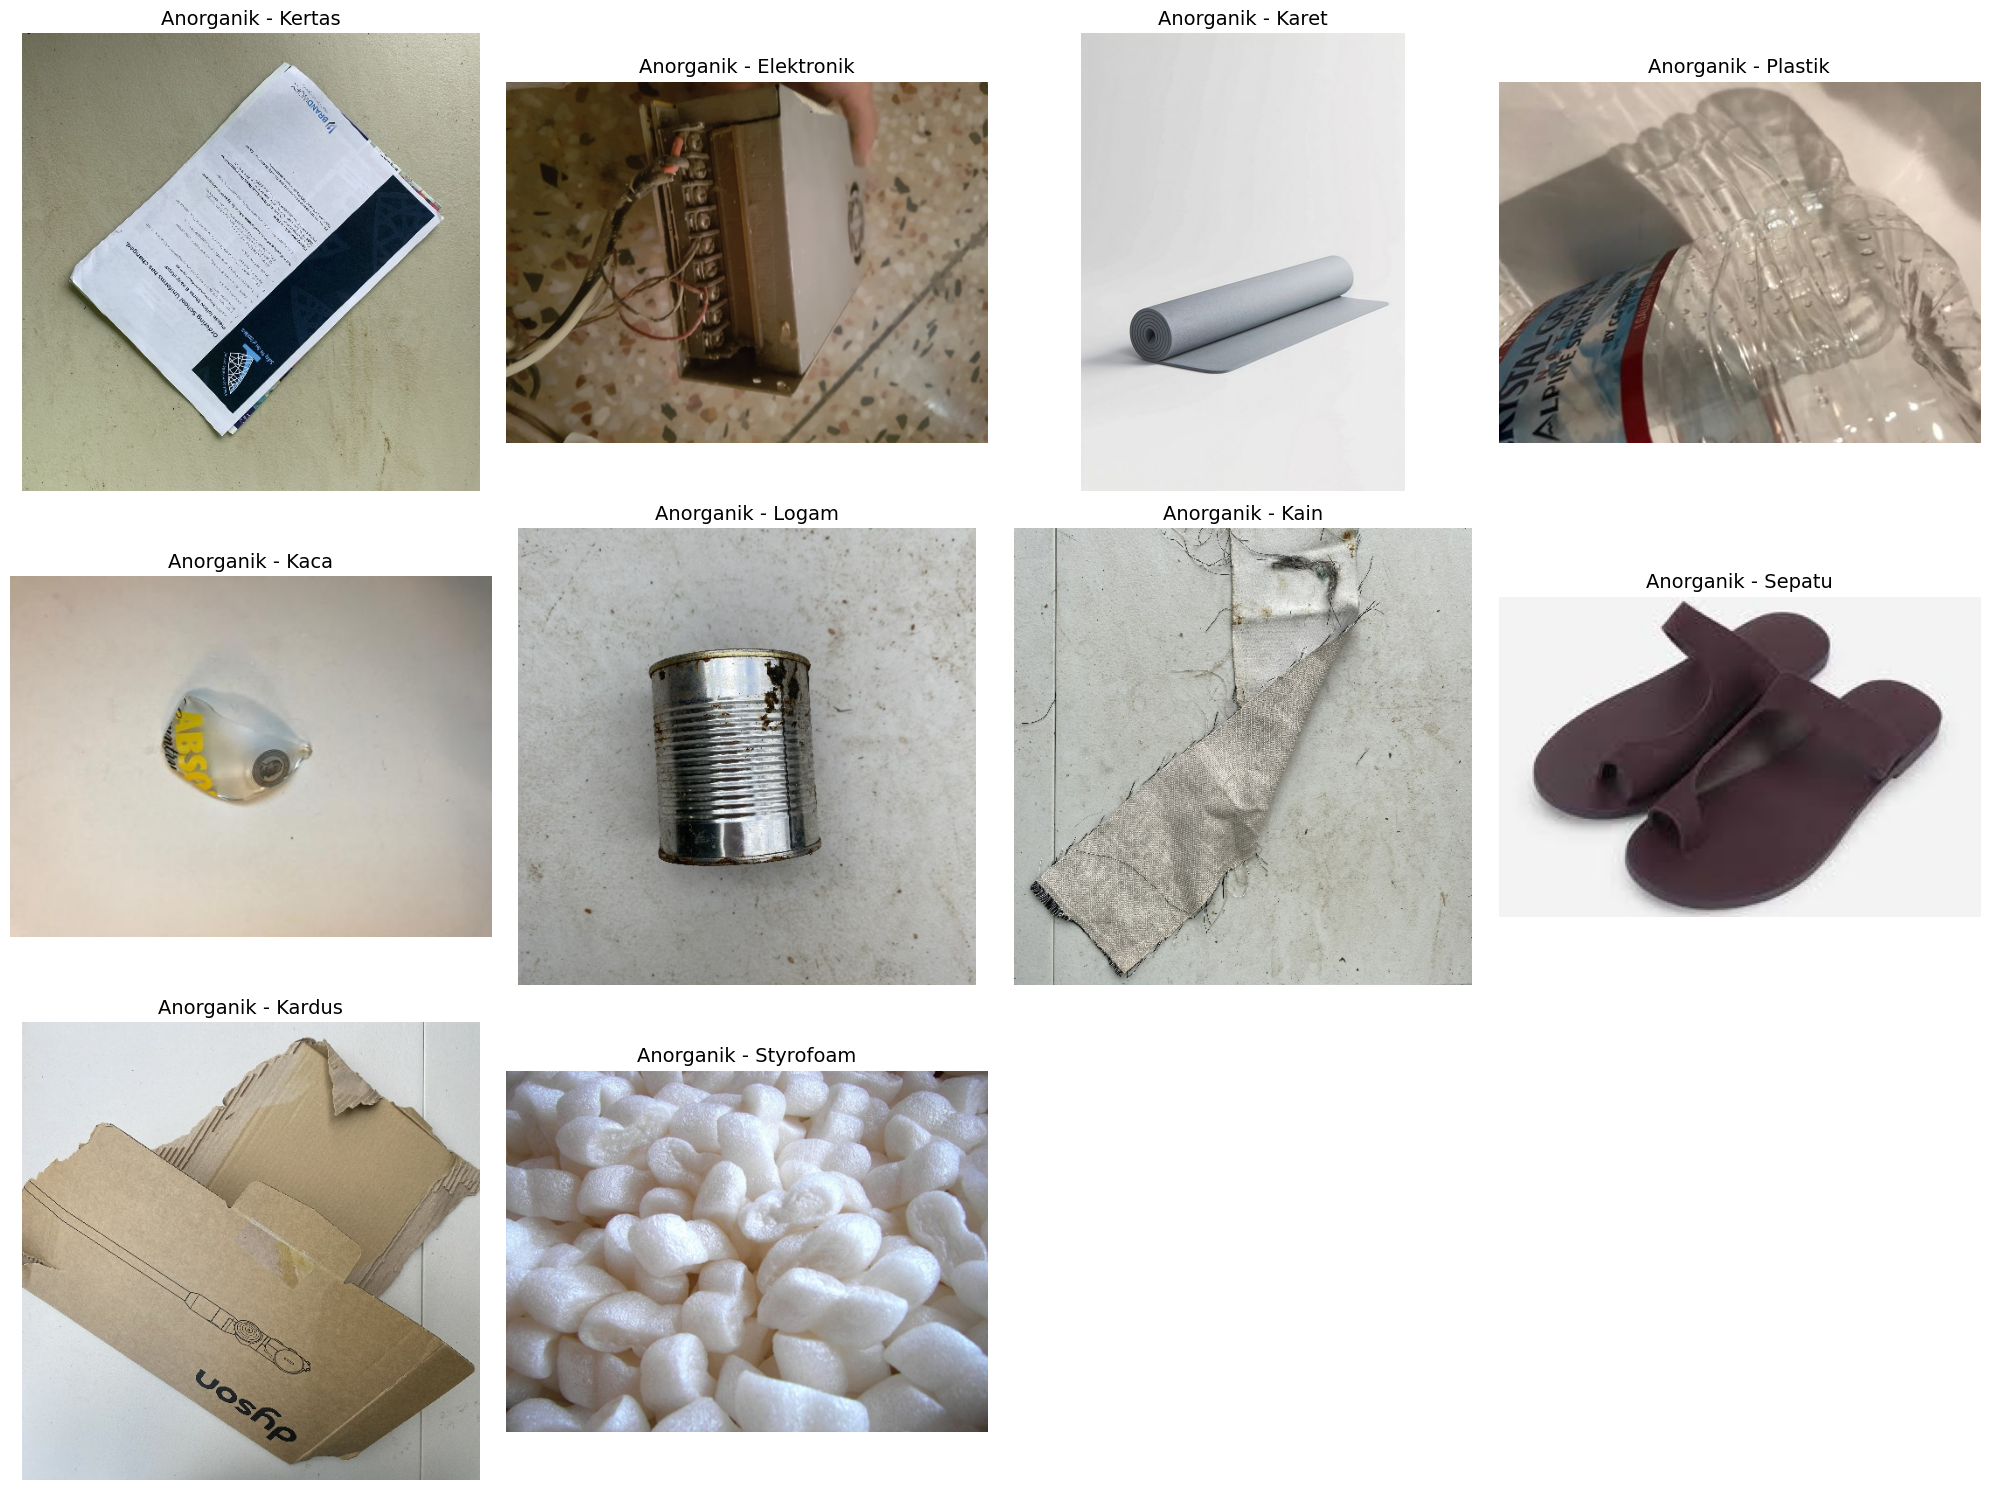


--- Contoh gambar dari kelas di folder 'Organik' ---


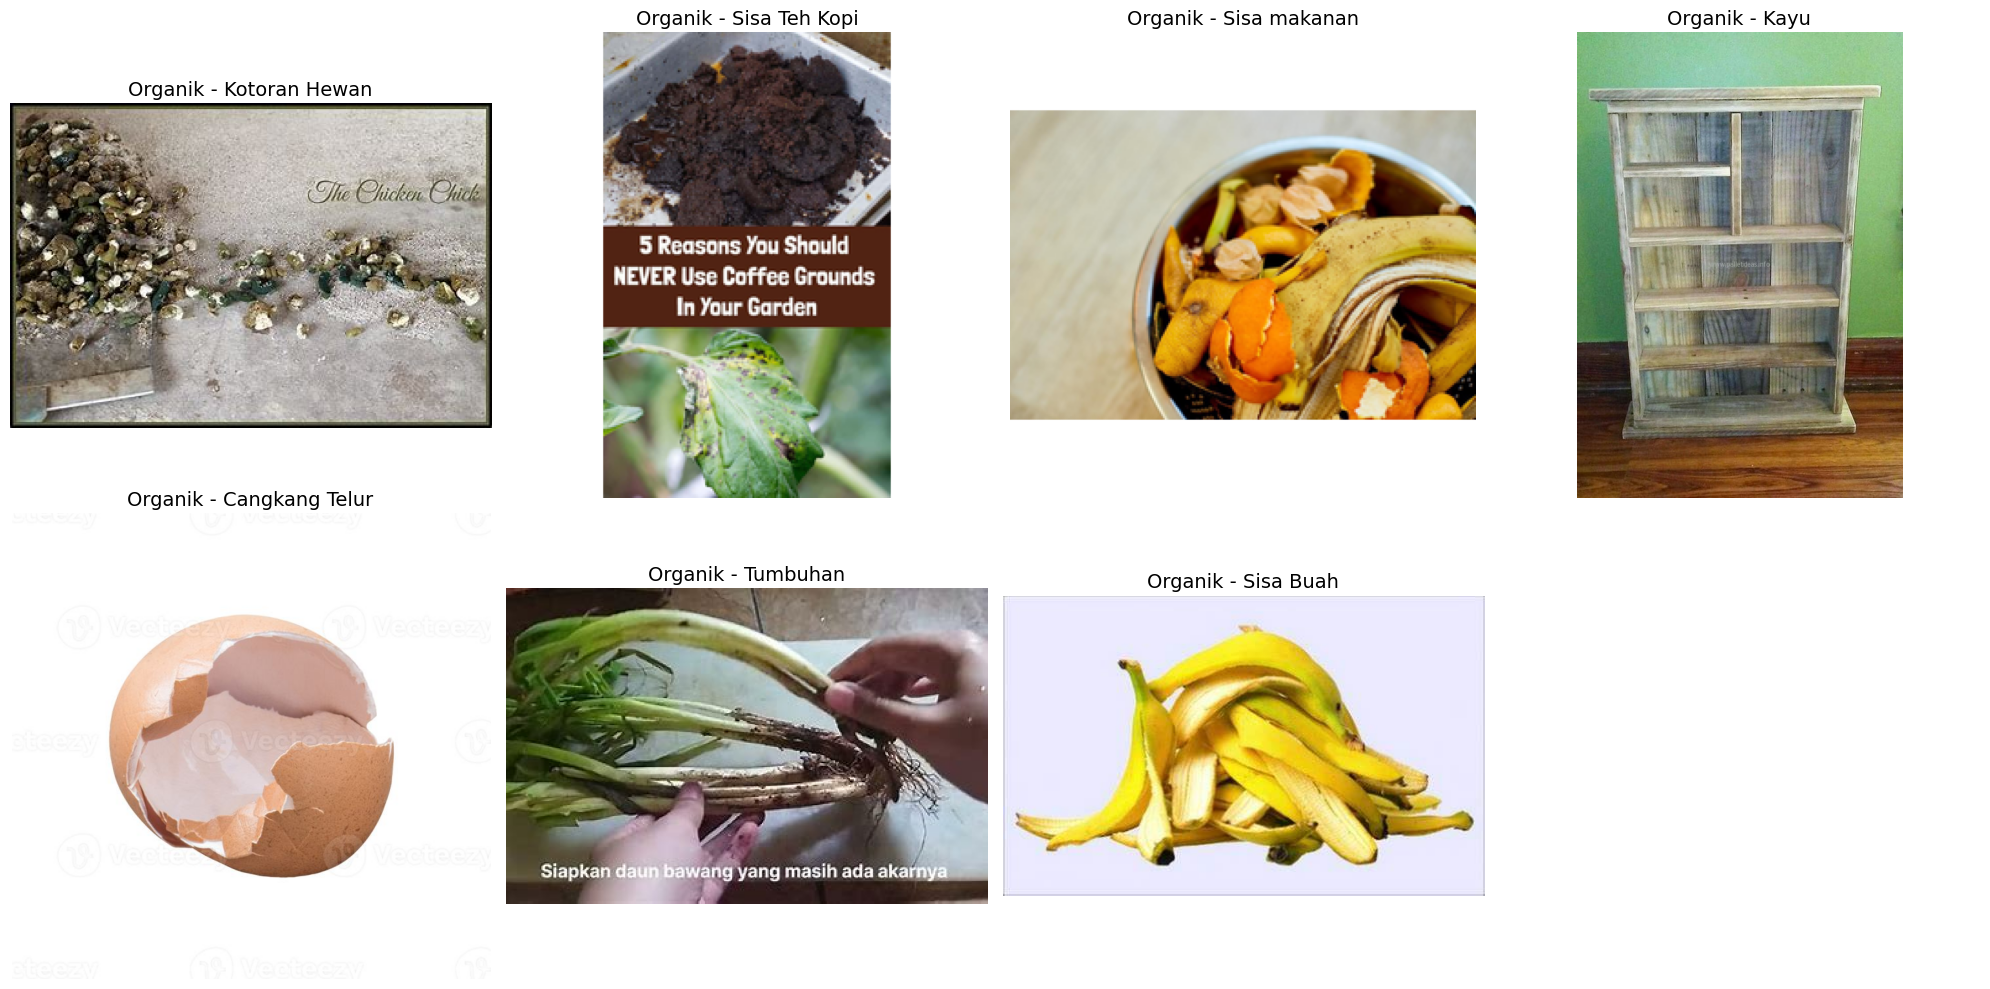

In [9]:
def show_sample_images(base_dir, main_folders):
    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            print(f"Folder {main_folder} tidak ditemukan.")
            continue

        print(f"\n--- Contoh gambar dari kelas di folder '{main_folder}' ---")
        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]

        images = []
        titles = []

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            files = [f for f in os.listdir(kelas_path) if os.path.splitext(f)[1].lower() in valid_extensions]

            if len(files) == 0:
                print(f"Tidak ada gambar valid di kelas '{kelas}'")
                continue

            contoh_gambar_path = os.path.join(kelas_path, files[0])
            img = cv2.imread(contoh_gambar_path)
            if img is None:
                print(f"Gagal membaca gambar {contoh_gambar_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            titles.append(f"{main_folder} - {kelas}")

        if len(images) == 0:
            print(f"Tidak ada gambar valid untuk ditampilkan di folder '{main_folder}'.")
            continue

        cols = 4
        total = len(images)
        rows = (total + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
        axes = axes.flatten() if total > 1 else [axes]

        for i in range(len(axes)):
            if i < total:
                axes[i].imshow(images[i])
                axes[i].set_title(titles[i], fontsize=14)
                axes[i].axis('off')
            else:
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Contoh pemanggilan fungsi
main_folders = ['Anorganik', 'Organik']
show_sample_images(working_dir, main_folders)

## Split Dataset

In [10]:
# split data 80% Train, 10% Test, 10% Val

working_dir = '/kaggle/working/dataset-capstone'
output_dir = '/kaggle/working/Dataset-Split'

main_folders = ['Anorganik', 'Organik']
splits = {
    'Train': 0.8,
    'Test': 0.1,
    'Val': 0.1
}

valid_extensions = ('.jpg', '.jpeg', '.png')

random.seed(42)

def create_dir_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

def split_dataset(base_dir, output_dir, main_folders, splits):

    for split_name in splits.keys():
        for main_folder in main_folders:
            create_dir_if_not_exist(os.path.join(output_dir, split_name, main_folder))

    for main_folder in main_folders:
        main_path = os.path.join(base_dir, main_folder)
        if not os.path.isdir(main_path):
            print(f"Folder {main_folder} tidak ditemukan, skip.")
            continue

        kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]

        for kelas in kelas_list:
            kelas_path = os.path.join(main_path, kelas)
            files = [f for f in os.listdir(kelas_path) if f.lower().endswith(valid_extensions)]

            random.shuffle(files)

            n_total = len(files)
            n_train = int(n_total * splits['Train'])
            n_test = int(n_total * splits['Test'])
            n_val = n_total - n_train - n_test

            train_files = files[:n_train]
            test_files = files[n_train:n_train+n_test]
            val_files = files[n_train+n_test:]

            for split_name, file_list in zip(['Train', 'Test', 'Val'], [train_files, test_files, val_files]):
                kelas_output_path = os.path.join(output_dir, split_name, main_folder, kelas)
                create_dir_if_not_exist(kelas_output_path)

                for file_name in file_list:
                    src_path = os.path.join(kelas_path, file_name)
                    dst_path = os.path.join(kelas_output_path, file_name)
                    shutil.copy2(src_path, dst_path)

            print(f"{main_folder}/{kelas}: total={n_total}, train={len(train_files)}, test={len(test_files)}, val={len(val_files)}")

split_dataset(working_dir, output_dir, main_folders, splits)

Anorganik/Kertas: total=600, train=480, test=60, val=60
Anorganik/Elektronik: total=517, train=413, test=51, val=53
Anorganik/Karet: total=533, train=426, test=53, val=54
Anorganik/Plastik: total=717, train=573, test=71, val=73
Anorganik/Kaca: total=750, train=600, test=75, val=75
Anorganik/Logam: total=598, train=478, test=59, val=61
Anorganik/Kain: total=450, train=360, test=45, val=45
Anorganik/Sepatu: total=508, train=406, test=50, val=52
Anorganik/Kardus: total=580, train=464, test=58, val=58
Anorganik/Styrofoam: total=457, train=365, test=45, val=47
Organik/Kotoran Hewan: total=496, train=396, test=49, val=51
Organik/Sisa Teh Kopi: total=586, train=468, test=58, val=60
Organik/Sisa makanan: total=788, train=630, test=78, val=80
Organik/Kayu: total=533, train=426, test=53, val=54
Organik/Cangkang Telur: total=660, train=528, test=66, val=66
Organik/Tumbuhan: total=791, train=632, test=79, val=80
Organik/Sisa Buah: total=795, train=636, test=79, val=80


Dapat dilihat output diatas merupakan hasil split data dengan rasio Train 80, Test 10, dan Val 10

In [11]:
# menghitung jumlah gambar train, val, dan test
def count_images_in_split(output_dir, main_folders, splits):
    print("\nTotal jumlah gambar per split:")
    for split_name in splits.keys():
        total_count = 0
        split_path = os.path.join(output_dir, split_name)
        for main_folder in main_folders:
            main_path = os.path.join(split_path, main_folder)
            if not os.path.isdir(main_path):
                continue
            kelas_list = [k for k in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, k))]
            for kelas in kelas_list:
                kelas_path = os.path.join(main_path, kelas)
                files = [f for f in os.listdir(kelas_path) if f.lower().endswith(valid_extensions)]
                total_count += len(files)
        print(f"{split_name}: {total_count} gambar")

count_images_in_split(output_dir, main_folders, splits)



Total jumlah gambar per split:
Train: 8281 gambar
Test: 1029 gambar
Val: 1049 gambar


## Data Preprocessing

In [12]:
# Augmentasi, Resize dan Normalisasi untuk folder train
from skimage import exposure

# custom contrast
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# path folder train setelah split
train_folder = os.path.join(output_dir, 'Train')

train_datagen = ImageDataGenerator(
    rescale=1./255,               # normalisasi
    rotation_range=30,            # rotasi
    width_shift_range=0.2,        # translasi horizontal
    height_shift_range=0.2,       # translasi vertikal
    shear_range=0.3,              # shearing
    zoom_range=0.3,               # zoom
    horizontal_flip=True,         # flip horizontal
    fill_mode='nearest',
    channel_shift_range=50,       # perpindahan warna channel
    ##preprocessing_function=contrast_stretching  # fungsi contrast stretching
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),  # resize gambar ke ukuran 224x224
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

print("Folder 'train' berhasil diproses dengan ImageDataGenerator.")
print(f"Jumlah kelas: {len(train_generator.class_indices)}")

Found 8281 images belonging to 2 classes.
Folder 'train' berhasil diproses dengan ImageDataGenerator.
Jumlah kelas: 2


In [13]:
# Normalisasi untuk folder Test dan Validation
test_folder = os.path.join(output_dir, 'Test')
val_folder = os.path.join(output_dir, 'Val')

val_test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_test_datagen.flow_from_directory(
    val_folder,
    batch_size=32,
    target_size=(224, 224),  # ini juga harus sama
    class_mode='categorical',
    shuffle=False,
    color_mode= 'rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_folder,
    batch_size=32,
    target_size=(224, 224),  # ini juga harus sama
    class_mode='categorical',
    shuffle=False,
    color_mode= 'rgb'
)

# Output informasi sukses untuk validation
print("Folder 'validation' berhasil diproses dengan ImageDataGenerator.")
print(f"Jumlah kelas (val): {len(val_generator.class_indices)}")

# Output informasi sukses untuk test
print("Folder 'test' berhasil diproses dengan ImageDataGenerator.")
print(f"Jumlah kelas (test): {len(test_generator.class_indices)}")

Found 1049 images belonging to 2 classes.
Found 1029 images belonging to 2 classes.
Folder 'validation' berhasil diproses dengan ImageDataGenerator.
Jumlah kelas (val): 2
Folder 'test' berhasil diproses dengan ImageDataGenerator.
Jumlah kelas (test): 2


In [14]:
print(f"Mapping kelas: {train_generator.class_indices}")
print(f"Mapping kelas (val): {val_generator.class_indices}")
print(f"Mapping kelas (test): {test_generator.class_indices}")

Mapping kelas: {'Anorganik': 0, 'Organik': 1}
Mapping kelas (val): {'Anorganik': 0, 'Organik': 1}
Mapping kelas (test): {'Anorganik': 0, 'Organik': 1}


# **3. Modelling**

In [15]:
import numpy as np
from collections import Counter

# Menghitung jumlah data per label
label_counts = Counter(train_generator.classes)

# Mengambil mapping label
label_map = train_generator.class_indices
label_map_inv = {v: k for k, v in label_map.items()}

# Menampilkan hasil
for label_index, count in label_counts.items():
    print(f"{label_map_inv[label_index]}: {count} gambar")

Anorganik: 4565 gambar
Organik: 3716 gambar


In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ambil semua label dari generator
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.9070098576122673), 1: np.float64(1.1142357373519913)}


In [17]:
from tensorflow.keras.applications import MobileNetV2

# Input layer
input_tensor = Input(shape=(224, 224, 3),name='gambar_input')

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
print("Jumlah total layer:", len(base_model.layers))

# Set semua layer dapat dilatih terlebih dahulu
base_model.trainable = True

# Bekukan semua layer kecuali 60 terakhir
for layer in base_model.layers[:-60]:
    layer.trainable = False

# Tambahkan custom layers di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(len(train_generator.class_indices), activation='softmax',name='prediksi_output')(x)

# Buat model final
model = Model(inputs=input_tensor, outputs=output_tensor)

# Lihat arsitektur model
model.summary()

/tmp/ipython-input-1065130225.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Jumlah total layer: 154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gambar_input        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ gambar_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,119,938 (8.09 MB)

 Non-trainable params: 302,272 (1.15 MB)

In [18]:

# Callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,             # jika val_loss tidak membaik selama 5 epoch, training stop
    restore_best_weights=True,
    verbose=1
)

# Compile dan fit dengan epochs 50 dan callbacks
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[reduce_lr, early_stop],

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
120/259 ━━━━━━━━━━━━━━━━━━━━ 3:25 1s/step - accuracy: 0.7437 - loss: 0.5377

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


259/259 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8090 - loss: 0.4176 - val_accuracy: 0.8675 - val_loss: 0.4452 - learning_rate: 1.0000e-04
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.9321 - loss: 0.1754 - val_accuracy: 0.9266 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.9574 - loss: 0.1173 - val_accuracy: 0.9514 - val_loss: 0.1573 - learning_rate: 1.0000e-04
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.9647 - loss: 0.0974 - val_accuracy: 0.9781 - val_loss: 0.0857 - learning_rate: 1.0000e-04
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.9723 - loss: 0.0712 - val_accuracy: 0.9619 - val_loss: 0.1423 - learning_rate: 1.0000e-04
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9708 - loss: 0.0758 - val_accuracy: 0.9752 - val_loss: 0.0818 - learning_rate: 1.0000e-04
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.97

# **4. Evaluasi Model dan Visualisasi**

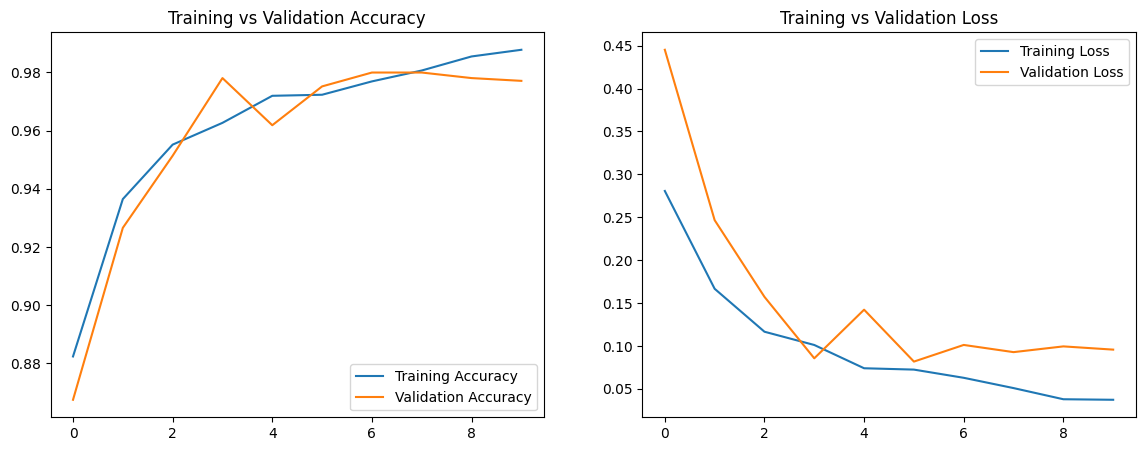

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# ===== 1. VISUALISASI =====
# Menggabungkan history1 dan history2 jika kamu mau, tapi di sini hanya history2
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 788ms/step
=== Classification Report ===
              precision    recall  f1-score   support

   Anorganik       0.97      0.98      0.97       567
     Organik       0.97      0.96      0.96       462

    accuracy                           0.97      1029
   macro avg       0.97      0.97      0.97      1029
weighted avg       0.97      0.97      0.97      1029



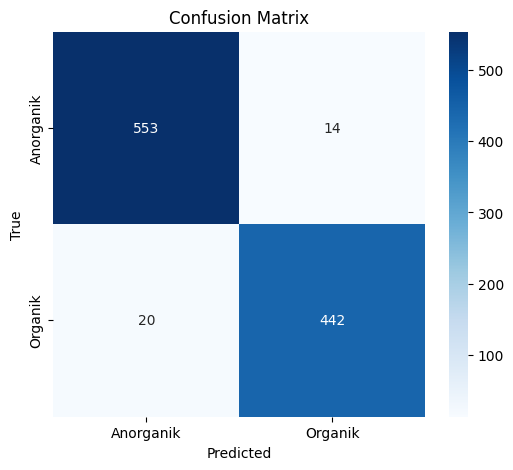

In [20]:
# Ambil prediksi model
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **5. Konversi Model**

In [21]:
model.save("model_organik_anorganik.h5")

In [22]:
from IPython.display import FileLink
FileLink('model_organik_anorganik.h5')  # klik link yang muncul untuk download

/content/model_organik_anorganik.h5

In [23]:
!pip install tf2onnx


INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 138.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6

In [24]:
# Tentukan nama file output Anda
H5_FILENAME = "model_organik_anorganik.h5"
ONNX_FILENAME = "model_organik_anorganik.onnx"

print(f"\nMenyimpan model ke format H5: {H5_FILENAME}...")
model.save(H5_FILENAME)
print(f"Model H5 berhasil disimpan.")

# Import tf2onnx
import tf2onnx

# Spesifikasi input untuk konverter ONNX. Ini sangat penting.
# Kita ambil spesifikasi langsung dari model yang sudah ada.
input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name=model.inputs[0].name)]

print(f"\nMengonversi model dari H5 ke format ONNX: {ONNX_FILENAME}...")
print(f"Spesifikasi Input yang digunakan: {input_signature}")

# Jalankan konversi. opset=13 adalah versi yang stabil dan direkomendasikan.
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)

# Simpan model ONNX ke file
with open(ONNX_FILENAME, "wb") as f:
    f.write(model_proto.SerializeToString())

print(f"Model ONNX berhasil dibuat dan disimpan sebagai '{ONNX_FILENAME}'.")

# ================================================================
# Langkah 5: Verifikasi dan Download
# ================================================================

# Verifikasi bahwa file sudah ada di direktori kerja Kaggle
print("\nFile yang ada di direktori kerja saat ini:")
!ls -lh

print("\n--- PROSES SELESAI ---")
print(f"✅✅✅ Silakan download file '{ONNX_FILENAME}' dari panel 'Data' -> 'Output' di sebelah kanan layar Anda.")


Menyimpan model ke format H5: model_organik_anorganik.h5...
Model H5 berhasil disimpan.

Mengonversi model dari H5 ke format ONNX: model_organik_anorganik.onnx...
Spesifikasi Input yang digunakan: [TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='gambar_input')]


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c3a1cd92660>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model ONNX berhasil dibuat dan disimpan sebagai 'model_organik_anorganik.onnx'.

File yang ada di direktori kerja saat ini:
total 36M
-rw-r--r-- 1 root root  26M Oct  4 05:38 model_organik_anorganik.h5
-rw-r--r-- 1 root root 9.2M Oct  4 05:38 model_organik_anorganik.onnx
drwxr-xr-x 1 root root 4.0K Oct  2 13:36 sample_data

--- PROSES SELESAI ---
✅✅✅ Silakan download file 'model_organik_anorganik.onnx' dari panel 'Data' -> 'Output' di sebelah kanan layar Anda.
